# Completeness of OSM building data

In this notebook, we demonstrate how to analyze the completeness of OSM building data for different study areas across the globe. 

The task can be done by only using data provided by the [Overture Maps Foundation](https://overturemaps.org/), a collaborative initiative to gather  geodata and provide open and global map data. The building data on Overture containes data of OpenStreetMaps, as well as other sources. We can use the labeled data to compare the OSM building data in Overture with data of other sources and get the completness of OSM building data.

The notebook contains following steps:

* Importing necessary libraries
* Create bounding boxes
* Downloading data from Overture Maps
* Data processing
* Visualizing the results

## Import packages
For handling the data we use the database system duckdb. Feel free to use the database management system you feel most confortable with. Please make sure that your chosen system supports the Structured Query Language (SQL).

In [1]:
import duckdb
import pandas as pd
import geopandas as gpd
import time
import matplotlib.pyplot as plt

## Create bounding boxes
With this method, you can check the completeness from any given area you are interested in. You only need to provide the coordinates of your area of interest as a bounding box. Here we have set a list of multiple bounding boxes of different cities as an example. Please note that downloading all the data of the example bounding boxes can last a few minutes. To speed the process up, you can adjust the bounding box list and shrink down the area of interest or put your own bounding box.

In [2]:
bboxes = {    
    'Berlin': (13.088345,52.338271,13.761161,52.675509),
    'Kathmandu': (85.188235,27.5701,85.565959,27.818056),
    'Vienna': (16.181831, 48.117907, 16.577513, 48.322668),
    'Nairobi': (36.650938,-1.444471,37.103887,-1.163522),
    'Rio_de_Janeiro':(-43.796252,-23.082705,-43.099081,-22.746088)
}

## Downloading data from Overture Maps
Configuring DuckDB

In [3]:
con = duckdb.connect(
    config={
        'threads': 8,
        'max_memory': '8GB',
    }
)

This function is downloading building data from Overture Maps for the defined study areas using DuckDB. 

In [4]:
def overture_download(region_name, xmin, ymin, xmax, ymax):

    query = f"""
    SET s3_region='us-west-2';

    CREATE OR REPLACE TABLE buildings_Overture_{region_name} AS
        (SELECT 
            id, 
            bbox,
            sources, 
            geometry
        FROM read_parquet('s3://overturemaps-us-west-2/release/2024-11-13.0/theme=buildings/type=building/*', filename=true, hive_partitioning=1)
        WHERE bbox.xmin > {xmin}
        AND bbox.ymin > {ymin}
        AND bbox.xmax < {xmax}
        AND bbox.ymax < {ymax}
        );
    """
    con.sql(query)

    print(f"Overture download completed for {region_name}")
    print("\n")


The download function is called and we define the study areas as our bounding box list. This step of downloading can last a few minutes.

In [5]:
for region_name, value in bboxes.items():
    xmin, ymin, xmax, ymax = bboxes[region_name]
    overture_download(region_name, xmin, ymin, xmax, ymax)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Overture download completed for Berlin




FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Overture download completed for Kathmandu




FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Overture download completed for Vienna




FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Overture download completed for Nairobi




FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Overture download completed for Rio_de_Janeiro




## Data processing
We first make sure that the data download was successful and contains all the regions of the bounding box list.

In [6]:
query = f"""
show tables 
"""
con.sql(query).show()

┌───────────────────────────────────┐
│               name                │
│              varchar              │
├───────────────────────────────────┤
│ buildings_Overture_Berlin         │
│ buildings_Overture_Kathmandu      │
│ buildings_Overture_Nairobi        │
│ buildings_Overture_Rio_de_Janeiro │
│ buildings_Overture_Vienna         │
└───────────────────────────────────┘



A loop is employed to run over all created tables and give back the number of buildings with OpenStreetMap as source, buildings with other source and the percentage of OSM building of the total count. Those numbers are saved in a data frame.

In [7]:
results = []

for region_name in bboxes.keys():
    query = f"""
    SELECT 
        '{region_name}' AS region, 
        SUM(CASE
            WHEN sources[1]['dataset'] = 'OpenStreetMap' THEN 1
            ELSE 0
        END) AS osm_count,
  
        SUM(CASE
            WHEN sources[1]['dataset'] != 'OpenStreetMap' THEN 1
            ELSE 0
        END) AS other_count,
        
        COUNT(*) AS total_count,
        ROUND((osm_count * 1.0 / total_count), 2) AS osm_completeness 
    FROM buildings_Overture_{region_name}
    """

    df = pd.DataFrame(
        con.sql(query).fetchall(), 
        columns=['Region', 'OSM', 'Other Sources', 'Total Count', 'OSM Completeness']
    )
    
    results.append(df)

final_result = pd.concat(results, ignore_index=True)

display(final_result)

,Region,OSM,Other Sources,Total Count,OSM Completeness
0,Berlin,706122,185767,891889,0.79
1,Kathmandu,494058,419939,913997,0.54
2,Vienna,295496,15974,311470,0.95
3,Nairobi,535583,782270,1317853,0.41
4,Rio_de_Janeiro,322461,1769997,2092458,0.15


## Visualize the completeness of OSM buildings
### Visualize results with a standard bar chart
The results can be visualized in different ways. We chose a bar chart to highlight how much the completeness of OSM building data can differ from region to region. 

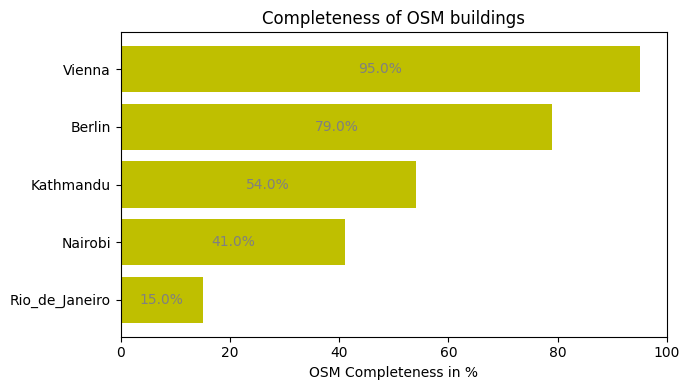

In [8]:
sorted_results = final_result.sort_values(by='OSM Completeness', ascending=True)

plt.figure(figsize=(7, 4)) 

bars = plt.barh(
    sorted_results['Region'], 
    100*sorted_results['OSM Completeness'], 
    color='y'
)

plt.bar_label(
    bars, 
    labels=[f'{x:.1f}%' for x in 100 * sorted_results['OSM Completeness']], 
    label_type='center',
    color='grey'
)

plt.title('Completeness of OSM buildings')
plt.xlabel('OSM Completeness in %')

plt.xlim([0,100])

plt.tight_layout()
plt.show()

### Visualize results with a lonboard map
The statistics and charts can give us overall numbers on the completeness, but we can access more detailed information by loading the results into a map. Here we have can see exacltly which buildings are included and which are missing in the OSM dataset.

For loading the results in a map we use [lonboard](https://developmentseed.org/lonboard/latest/). We visualized the results of the city Berlin. Feel free to try it with your own area of interest.

Herefore, we first need to access the spatial dimensions of our downloaded data, transfere it into a geodataframe and transform it to a suitable coordinate reference system.

In [9]:
con.sql("INSTALL spatial;")
con.sql("LOAD spatial;")

Calling the data from DuckDB.

In [10]:
region_name = "Berlin"

query = f"""
SELECT 
    ST_AsText(ST_GeomFromWKB(geometry)) AS geometry,
    sources[1]['dataset'] AS source
FROM buildings_Overture_{region_name}
"""
df = con.sql(query).df()

Setting up the geodataframe.

In [11]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.GeoSeries.from_wkt(df['geometry'])
).set_crs('epsg:4326')

We want the colour codes shown in the map to be based on the source of the building data (OSM or other source). Here we convert the source into a cathegory.

In [12]:
gdf["source_codes"] = 1
gdf.loc[gdf['source'] == 'OpenStreetMap', 'source_codes'] = 0

Let's have a look at our geodataframe and the different the categories we have set up.

In [18]:
display(gdf)
display(gdf['source'].unique())

,geometry,source,source_codes
0,"POLYGON ((13.09111 52.33882, 13.0913 52.33875,...",OpenStreetMap,0
1,"POLYGON ((13.09142 52.33869, 13.09138 52.3387,...",OpenStreetMap,0
2,"POLYGON ((13.092 52.33853, 13.09195 52.33848, ...",OpenStreetMap,0
3,"POLYGON ((13.09216 52.33845, 13.0921 52.33841,...",OpenStreetMap,0
4,"POLYGON ((13.09165 52.33855, 13.09168 52.33858...",OpenStreetMap,0
...,...,...,...
891891,"POLYGON ((13.72285 52.66864, 13.72285 52.6685,...",OpenStreetMap,0
891892,"POLYGON ((13.74536 52.67531, 13.7453 52.67531,...",Microsoft ML Buildings,1
891893,"POLYGON ((13.74532 52.67532, 13.74539 52.67531...",Microsoft ML Buildings,1
891894,"POLYGON ((13.74539 52.67541, 13.74536 52.67538...",Microsoft ML Buildings,1


array(['OpenStreetMap', 'Esri Community Maps', 'Microsoft ML Buildings'],
      dtype=object)

Now we can define the lonboard map layout.

In [14]:
import lonboard

# adjust color values
source_colormap = {
    0: [55, 126, 184, 255],
    1: [152, 78, 163, 255]
}

colors = lonboard.colormap.apply_categorical_cmap(
    gdf["source_codes"],
    source_colormap,
    alpha=1
)

layer = lonboard.SolidPolygonLayer.from_geopandas(
    gdf,
    get_fill_color=colors,
    extensions=[lonboard.layer_extension.DataFilterExtension(filter_size=1)],
    get_filter_value=gdf["source_codes"].astype('float'),  # Numerische Werte für den Filter
    filter_range=[0.0, 1.0],
)

Including toggle buttons

In [15]:
import ipywidgets
from traitlets import directional_link

# define toogle button name and value
group_options = [
    ("OpenStreetMap", 0),
    ("Other", 1)
]

source_toggle = ipywidgets.ToggleButtons(
    options=group_options,
    disabled=False,
)

directional_link(
    (source_toggle, 'value'),
    (layer, "filter_range"),
    transform=lambda v: (v, v)
)

Let's have a look at our map, displaying OSM building data and missing building data. Soom into the map to get a more detailed depiction.

In [19]:
building_map = lonboard.Map(
    basemap_style=lonboard.basemap.CartoBasemap.Positron,
    layers=[layer],
)

display(building_map, source_toggle)

Map(basemap_style=<CartoBasemap.Positron: 'https://basemaps.cartocdn.com/gl/positron-gl-style/style.json'>, cu…

ToggleButtons(options=(('OpenStreetMap', 0), ('Other', 1)), value=0)